In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
import pylab as plt
from scipy import stats
import os.path
import re
#%pylab inline

/Users/matthias/anaconda/lib/python2.7/site-packages/numexpr/cpuinfo.py:76: UserWarning: [Errno 2] No such file or directory
  stacklevel=stacklevel + 1):


In [4]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-03-25/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
path_all = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-04-27/"
files_start = 4547
files_end = 4713


In [5]:
# cup configuration
#cup_config = cycle_Sb
cup_config = cycles2
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "126"}
corr_isotopes_2 = {"Cd" : "111","Te" : "125", "Xe" : "129"}
corr_isotopes_Sb = {"Te": "125"}
# Mass Range of cup configuration
mass_range = cycles2_mass_range
#isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124"], ["117", "118", "119", "122", "124"]]
isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124", "125", "126", "129"]]
#isotopes = [["116", "117", "118", "119", "122", "124"]]
denom_isotope = "120"
isotope_column = ["111", "112", "114", "115", "116", "117", "118", "119", "122", "124", "125", "126", "129"]
data_sample_column = [(i + "/" + "120") for i in isotope_column]
print data_sample_column
#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = True

blk_corr = True

['111/120', '112/120', '114/120', '115/120', '116/120', '117/120', '118/120', '119/120', '122/120', '124/120', '125/120', '126/120', '129/120']


In [6]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    columns = df.columns.tolist()
    for column in columns:
        data_sample_outlier[column] = df[column].where(~mad_based_outlier(df[column]), other=np.NaN)
    return data_sample_outlier

In [7]:
filenames = os.listdir(path_all)

In [8]:
sample_ls = []
for i in filenames:
    sample = re.search(r""+"Data_"+"(.*).csv", i)
    if sample == None:
        None
    else:
        sample = sample.group(1)
        df = NU_data_read(path_all, sample, cup_config)
        sample_name = df.extract_metadata(sample, "Sample Name")
        sample_ls.append(sample)

In [9]:
columns = ["cycle", "sample", "date","H10 (Z1)", "H9 (Z1)", "H8 (Z1)", "H7 (Z1)", "H6 (Z1)", "H5 (Z1)", "H4 (Z1)", "H3 (Z1)", "H2 (Z1)", "H1 (Z1)", "Ax (Z1)", "L1 (Z1)", "L2 (Z1)", "L3 (Z1)", "L4 (Z1)"]
df_all = pd.DataFrame(columns = columns)
for sample in sample_ls:
    df = NU_data_read(path_all, sample, cup_config)
    datafile = "Data_" + str(sample) + ".csv"
    data = pd.read_csv(path_all + datafile, skiprows=58, index_col='Cycle')
    
    data_zero = data.ix[:,"H10 (Z1)":"L4 (Z1)"]
    data_zero["cycle"] = data_zero.index.values
        #data_1_corr = mad_outlier_rejection(data_1_corr)
        
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_zero["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_zero["sample"] = sample_name
    df_all = pd.concat([df_all,data_zero], axis=0, ignore_index=True)
    #df_all = df_all.append(data_1_corr)
    df_all = df_all[columns]
df_all.set_index("date", inplace = True)
df_all

/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

,cycle,sample,H10 (Z1),H9 (Z1),H8 (Z1),H7 (Z1),H6 (Z1),H5 (Z1),H4 (Z1),H3 (Z1),H2 (Z1),H1 (Z1),Ax (Z1),L1 (Z1),L2 (Z1),L3 (Z1),L4 (Z1)
date,,,,,,,,,,,,,,,,,
2017-04-27 18:51:00,1.0,blank sol,0.0,0.0,-0.005973,-0.001551,-0.005399,-0.006162,-0.003149,-0.002646,-0.004901,-0.004884,-0.005934,-0.005239,-0.004349,-0.003805,-0.001841
2017-04-27 18:51:00,2.0,blank sol,0.0,0.0,-0.005973,-0.001551,-0.005399,-0.006162,-0.003149,-0.002646,-0.004901,-0.004884,-0.005934,-0.005239,-0.004349,-0.003805,-0.001841
2017-04-27 18:51:00,3.0,blank sol,0.0,0.0,-0.005973,-0.001551,-0.005399,-0.006162,-0.003149,-0.002646,-0.004901,-0.004884,-0.005934,-0.005239,-0.004349,-0.003805,-0.001841
2017-04-27 18:51:00,4.0,blank sol,0.0,0.0,-0.005973,-0.001551,-0.005399,-0.006162,-0.003149,-0.002646,-0.004901,-0.004884,-0.005934,-0.005239,-0.004349,-0.003805,-0.001841
2017-04-27 18:51:00,5.0,blank sol,0.0,0.0,-0.005973,-0.001551,-0.005399,-0.006162,-0.003149,-0.002646,-0.004901,-0.004884,-0.005934,-0.005239,-0.004349,-0.003805,-0.001841
2017-04-27 18:51:00,6.0,blank sol,0.0,0.0,-0.005973,-0.001551,-0.005399,-0.006162,-0.003149,-0.002646,-0.004901,-0.004884,-0.005934,-0.005239,-0.004349,-0.003805,-0.001841
2017-04-27 18:51:00,7.0,blank sol,0.0,0.0,-0.005973,-0.001551,-0.005399,-0.006162,-0.003149,-0.002646,-0.004901,-0.004884,-0.005934,-0.005239,-0.004349,-0.003805,-0.001841
2017-04-27 18:51:00,8.0,blank sol,0.0,0.0,-0.005973,-0.001551,-0.005399,-0.006162,-0.003149,-0.002646,-0.004901,-0.004884,-0.005934,-0.005239,-0.004349,-0.003805,-0.001841
2017-04-27 18:51:00,9.0,blank sol,0.0,0.0,-0.005973,-0.001551,-0.005399,-0.006162,-0.003149,-0.002646,-0.004901,-0.004884,-0.005934,-0.005239,-0.004349,-0.003805,-0.001841


In [10]:
def mean(x):
    mean = np.nanmean(x) 
    return mean

df_all_mean = df_all.drop("cycle", axis=1).groupby(df_all.index).agg(mean)
df_all_mean["sample"] = df_all[~df_all.index.duplicated(keep='first')]["sample"]
df_all_mean
#(df_all_mean["H6 (1)"].mean() - (df_all_mean["H4 (1)"].mean()/24.22*32.6))*1000

,H10 (Z1),H9 (Z1),H8 (Z1),H7 (Z1),H6 (Z1),H5 (Z1),H4 (Z1),H3 (Z1),H2 (Z1),H1 (Z1),Ax (Z1),L1 (Z1),L2 (Z1),L3 (Z1),L4 (Z1),sample
date,,,,,,,,,,,,,,,,
2017-04-27 16:12:00,0.0,0.0,-0.005961,-0.001547,-0.005407,-0.006148,-0.003132,-0.002634,-0.004896,-0.004872,-0.005959,-0.005252,-0.004380,-0.003826,-0.001854,blank sol
2017-04-27 16:22:00,0.0,0.0,-0.005967,-0.001548,-0.005387,-0.006143,-0.003134,-0.002632,-0.004877,-0.004844,-0.005929,-0.005219,-0.004376,-0.003812,-0.001852,NIST 200ppb
2017-04-27 16:37:00,0.0,0.0,-0.005962,-0.001546,-0.005410,-0.006151,-0.003142,-0.002632,-0.004904,-0.004876,-0.005938,-0.005244,-0.004374,-0.003820,-0.001841,blank sol
2017-04-27 16:48:00,0.0,0.0,-0.005970,-0.001556,-0.005406,-0.006160,-0.003139,-0.002616,-0.004882,-0.004857,-0.005931,-0.005176,-0.004356,-0.003794,-0.001866,NIST 350ppb
2017-04-27 17:02:00,0.0,0.0,-0.005968,-0.001545,-0.005409,-0.006155,-0.003147,-0.002646,-0.004900,-0.004871,-0.005938,-0.005256,-0.004369,-0.003825,-0.001832,blank sol
2017-04-27 17:13:00,0.0,0.0,-0.005970,-0.001555,-0.005392,-0.006146,-0.003129,-0.002619,-0.004893,-0.004865,-0.005946,-0.005195,-0.004380,-0.003813,-0.001846,NIST 200ppb
2017-04-27 17:28:00,0.0,0.0,-0.005973,-0.001560,-0.005379,-0.006159,-0.003120,-0.002621,-0.004895,-0.004861,-0.005935,-0.005164,-0.004364,-0.003809,-0.001871,NIST 350ppb
2017-04-27 17:42:00,0.0,0.0,-0.005965,-0.001563,-0.005394,-0.006154,-0.003134,-0.002631,-0.004888,-0.004867,-0.005938,-0.005197,-0.004361,-0.003809,-0.001854,NIST 200ppb
2017-04-27 17:57:00,0.0,0.0,-0.005965,-0.001555,-0.005404,-0.006167,-0.003144,-0.002631,-0.004905,-0.004875,-0.005945,-0.005252,-0.004358,-0.003816,-0.001824,blank sol


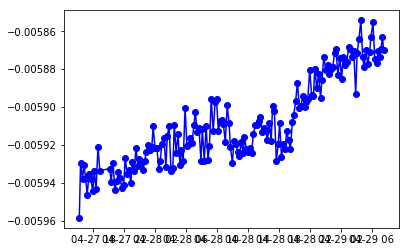

In [11]:
sel_cup = "Ax (Z1)"
plt.plot(df_all_mean.index, df_all_mean[sel_cup], linestyle='-', marker='o', color='b')
plt.show()

In [13]:
df_peak = pd.DataFrame(columns = ["date", "sample", "peak_center_mass"])
data_1_corr = pd.DataFrame()
for sample in blk_ls:
    df = NU_data_read(path_all, sample, cup_config)
    datafile = "Results_" + str(sample) + ".txt"
    sample_name = df.extract_metadata(sample, "Sample Name:")
    date = df.extract_metadata(sample, "Date and Time:")
    peak_center = df.extract_metadata(sample, "Axial Mass(es) used:")
    data_1_corr["date"] = datetime.strptime(date, '%d/%m/%Y%H:%M')
    data_1_corr["sample"] = sample_name
    data_1_corr["peak_center_mass"] = peak_center
    df_peak = pd.concat([df_peak,data_1_corr], axis=0, ignore_index=True)

df_peak

UnboundLocalError: local variable 'metadata' referenced before assignment

In [17]:
df_all.to_csv(path_all + "blanks.csv", mode='w', header=True)

In [18]:
df_all_mean.to_csv(path_all + "blanks_mean.csv", mode='w', header=True)

In [229]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_mean_no_bgd_corr.csv")

In [389]:
epsilon.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_epsilon_bgd_corr.csv")